## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [224]:
import numpy as np
import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib.ticker as ticker

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [258]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y).astype(np.int64)
        self.classes = np.max(self.y) + 1
    
    def predict(self, X, neighbors=None, return_neighbors=False): # последние два гиперпараметра здесь для классификации не нужны, 
                                                                # они введены, чтобы ускорить вычисления
        votes = np.zeros((X.shape[0], self.classes))
        if neighbors is None:
            if self.algorithm == 'brute':
                dist_matr = cdist(XA=X, XB=self.X, metric=self.metric)
                neighbors = np.argsort(dist_matr, axis=1)[:, :self.n_neighbors]
            if self.algorithm == 'kd_tree':
                neighbors = KDTree(self.X, metric=self.metric).query(X, k=self.n_neighbors)[1]
        labels = self.y[neighbors]
        for i in range(X.shape[0]):
            for j in range(self.classes):
                votes[i, j] = len(labels[i][labels[i] == j])
        y_predict = np.argmax(votes, axis=1)
        if return_neighbors:
            return y_predict, neighbors
        return y_predict

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [187]:
iris = datasets.load_iris()

In [188]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [189]:
X_train.shape, X_test.shape

((135, 4), (15, 4))

In [190]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [191]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [192]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [193]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [194]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [195]:
%time clf.predict(X_test)

Wall time: 3.84 ms


array([2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0])

In [196]:
%time my_clf.predict(X_test)

Wall time: 729 µs


array([2, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 0, 2, 0], dtype=int64)

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [204]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [198]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [205]:
%time clf.fit(X_train, y_train)

Wall time: 677 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [206]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [207]:
%time clf.predict(X_test)

Wall time: 2.75 ms


array([2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2])

In [208]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 2], dtype=int64)

In [209]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [249]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [250]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [181]:
vectorizer = CountVectorizer(min_df=0.001, max_df=0.95)
text_freq = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [182]:
kfold = KFold(n_splits=3, shuffle=True)

In [183]:
folds = []
for ind_train, ind_test in kfold.split(text_freq, target):
    folds.append((text_freq[ind_train].toarray(), target[ind_train], text_freq[ind_test].toarray(), target[ind_test]))

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Вычисления производятся очень долго. Поэтому немного их оптимизируем: заметим, что если мы нашли 10 ближайших соседей, то можно не искать заново 9, 8, ..., 1, потому что они уже найдены.

In [248]:
def find_opt_neighbors(folds, metric='euclidean', n=10):
    acc = np.zeros(n)
    for X in tqdm(folds):
        my_clf = MyKNeighborsClassifier(n_neighbors=10, metric=metric)
        my_clf.fit(X[0], X[1])
        pred, neighbors = my_clf.predict(X[2], return_neighbors=True)
        acc[9] += accuracy_score(pred, X[3])
        for i in range(1, 10):
            pred = my_clf.predict(X[2], neighbors = neighbors[:, :i])
            acc[i - 1] += accuracy_score(pred, X[3])
    acc /= 3
    return np.argmax(acc) + 1, acc

In [217]:
opt_n, acc = find_opt_neighbors(folds)

100%|██████████| 3/3 [14:58<00:00, 299.53s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


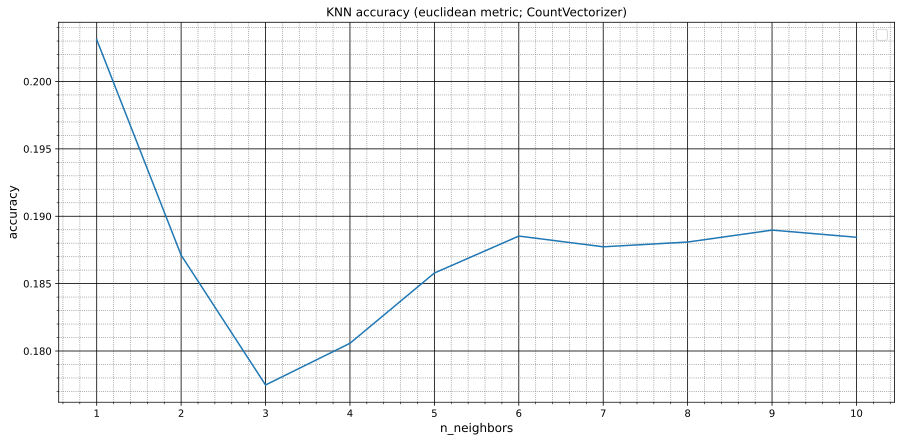

In [259]:
fig, ax = plt.subplots(figsize=(15,7)) 
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.tick_params(which='major', length=5, color='k', direction='in', top="on", right="on")
plt.plot(np.arange(10) + 1, acc)
plt.legend(fontsize = 14)
plt.title("KNN accuracy (euclidean metric; CountVectorizer)")
plt.show()

In [221]:
opt_n

1

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [222]:
opt_n_cos, acc_cos = find_opt_neighbors(folds, metric='cosine')

100%|██████████| 3/3 [21:36<00:00, 432.17s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


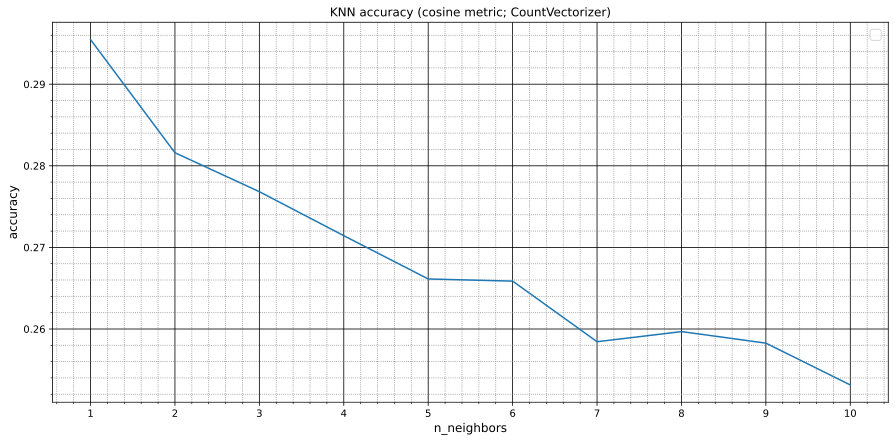

In [260]:
fig, ax = plt.subplots(figsize=(15,7)) 
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(np.arange(10) + 1, acc_cos)
plt.legend(fontsize = 14)
plt.title("KNN accuracy (cosine metric; CountVectorizer)")
plt.show()

In [225]:
opt_n_cos

1

In [251]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.95)
X_train = vectorizer.fit_transform(data)

In [228]:
folds = []
for ind_train, ind_test in kfold.split(X_train, target):
    folds.append((X_train[ind_train].toarray(), target[ind_train], X_train[ind_test].toarray(), target[ind_test]))

In [230]:
opt_n_tfidf, acc_tfidf = find_opt_neighbors(folds)

100%|██████████| 3/3 [09:32<00:00, 190.67s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


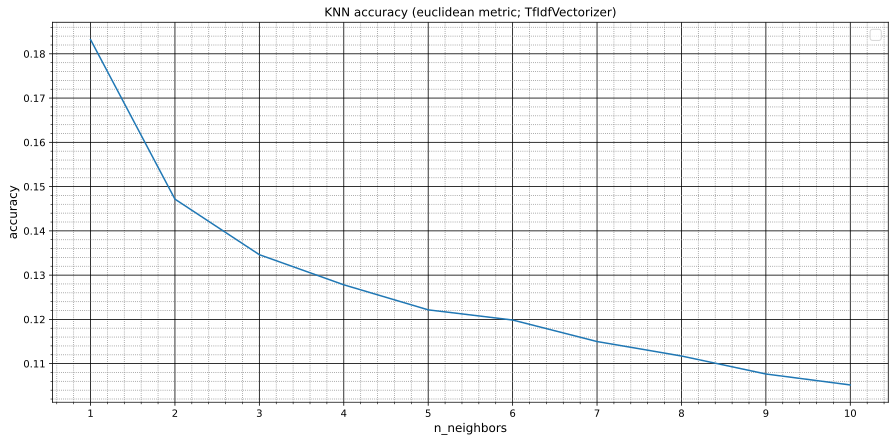

In [261]:
fig, ax = plt.subplots(figsize=(15,7)) 
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(np.arange(10) + 1, acc_tfidf)
plt.legend(fontsize = 14)
plt.title("KNN accuracy (euclidean metric; TfIdfVectorizer)")
plt.show()

In [233]:
opt_n_tfidf

1

In [232]:
opt_n_tfidf_cos, acc_tfidf_cos = find_opt_neighbors(folds, metric='cosine')

100%|██████████| 3/3 [21:24<00:00, 428.12s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


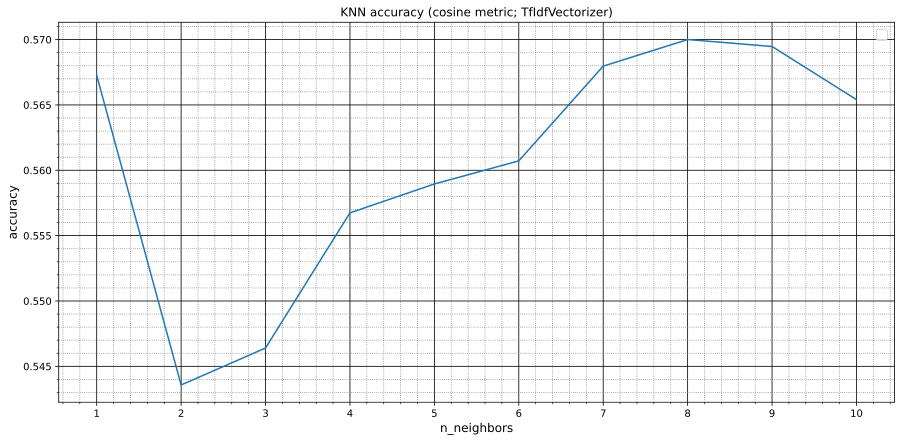

In [262]:
fig, ax = plt.subplots(figsize=(15,7)) 
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(np.arange(10) + 1, acc_tfidf_cos)
plt.legend(fontsize = 14)
plt.title("KNN accuracy (cosine metric; TfIdfVectorizer)")
plt.show()

In [235]:
opt_n_tfidf_cos

8

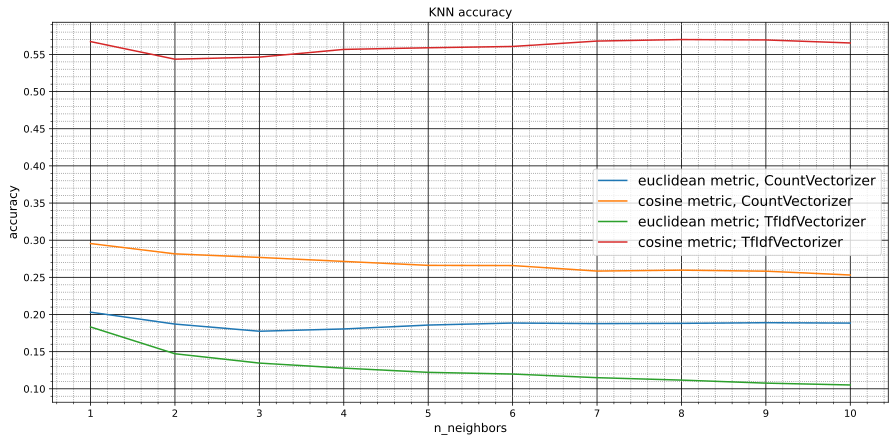

In [244]:
fig, ax = plt.subplots(figsize=(15,7)) 
plt.xlabel('n_neighbors', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
plt.plot(np.arange(10) + 1, acc, label='euclidean metric, CountVectorizer')
plt.plot(np.arange(10) + 1, acc_cos, label='cosine metric, CountVectorizer')
plt.plot(np.arange(10) + 1, acc_tfidf, label='euclidean metric; TfIdfVectorizer')
plt.plot(np.arange(10) + 1, acc_tfidf_cos, label='cosine metric; TfIdfVectorizer')
plt.legend(fontsize = 14)
plt.title("KNN accuracy")
plt.show()

**Вывод**: отсюда видно, что лучшая точность достигается при использовании косинусной метрики, TfIdf-векторизации и 8 соседях.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [253]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [254]:
data = newsgroups['data']
target_test = newsgroups['target']

In [255]:
X_test = vectorizer.transform(data)

In [256]:
my_clf = MyKNeighborsClassifier(n_neighbors=8, metric='cosine')
my_clf.fit(X_train.toarray(), target)
pred = my_clf.predict(X_test.toarray())
accuracy_score(pred, target_test)

0.5069038767923526

**Выводы:** качество на кросс-валидации составило 0.57, а на тесте всего 0.5. Но это логично, потому что, подбирая параметры, мы ориентировались на обучающую выборку (то есть не имели полной картины происходящего). Также может отличаться словарь, поэтому векторизация тестовой части могла произойти не совсем корректно. Ну и, к тому же, параметры min_df и max_df выбраны интуитивно. Возможно, нужна лучшая предобработка данных, чтобы можно было более точно подобрать эти параметры и тем самым улучшить качество классификации.